# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import math

from agent import Agent

%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
env_info = env.reset(train_mode=True)[brain_name]

### Deep-Q Learning Function

In [7]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, train_mode=True, 
        ckpt_path='checkpoints/checkpoint.pth'):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    rolling_avgs = []                  # list of rolling averages
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes + 1):
        
        env_info = env.reset(train_mode=train_mode)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state

        score = 0
        for t in range(max_t):           
            action = agent.act(state, eps)                 # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)          # save most recent score
        scores.append(score)                 # save most recent score
        rolling_avg = np.mean(scores_window) # calculate rolling average
        rolling_avgs.append(rolling_avg)               # save most recent rolling average
        eps = max(eps_end, eps_decay*eps)    # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, rolling_avg), end="")
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), ckpt_path)
            break
            
    return scores, rolling_avgs

In [8]:
methods = [
    { 'label': 'DQN (32 nodes)', 'nodes': 32, 'use_dropout': False, 'use_dueling': False, 'use_double': False, 'save_name': 'dqn_32_checkpoint' },
    { 'label': 'DQN (64 nodes)', 'nodes': 64, 'use_dropout': False, 'use_dueling': False, 'use_double': False, 'save_name': 'dqn_64_checkpoint' },
    { 'label': 'DQN (128 nodes)', 'nodes': 128, 'use_dropout': False, 'use_dueling': False, 'use_double': False, 'save_name': 'dqn_128_checkpoint' },
    { 'label': 'DQN + DO (32 nodes)', 'nodes': 32, 'use_dropout': True, 'use_dueling': False, 'use_double': False, 'save_name': 'dqn_do_32_checkpoint' },
    { 'label': 'DQN + DO (64 nodes)', 'nodes': 64, 'use_dropout': True, 'use_dueling': False, 'use_double': False, 'save_name': 'dqn_do_64_checkpoint' },
    { 'label': 'DQN + Duel (32 nodes)', 'nodes': 32, 'use_dropout': False, 'use_dueling': True, 'use_double': False, 'save_name': 'dqn_duel_32_checkpoint' },
    { 'label': 'DQN + Duel (64 nodes)', 'nodes': 64, 'use_dropout': False, 'use_dueling': True, 'use_double': False, 'save_name': 'dqn_duel_64_checkpoint' },
    { 'label': 'DDQN (32 nodes)', 'nodes': 32, 'use_dropout': False, 'use_dueling': False, 'use_double': True, 'save_name': 'ddqn_32_checkpoint' },
    { 'label': 'DDQN (64 nodes)', 'nodes': 64, 'use_dropout': False, 'use_dueling': False, 'use_double': True, 'save_name': 'ddqn_64_checkpoint' },
    { 'label': 'DDQN (128 nodes)', 'nodes': 128, 'use_dropout': False, 'use_dueling': False, 'use_double': True, 'save_name': 'ddqn_128_checkpoint' },
]

In [9]:
data = []
for ii in range(len(methods)):
    method = methods[ii]
    print('Starting {}'.format(method['label']))
        
    # Reset environment
    env_info = env.reset(train_mode=True)[brain_name]

    # Train the agent
    agent = Agent(
        state_size=state_size,
        action_size=action_size,
        seed=0, layer_1=method['nodes'],
        layer_2=method['nodes'],
        use_dropout=method['use_dropout'],
        use_dueling=method['use_dueling'],
        use_double=method['use_double']
    )
    scores, avgs = dqn(
        n_episodes=500,
        eps_start=1.0,
        eps_end=0.02, 
        eps_decay=0.98,
        train_mode=True,
        ckpt_path="checkpoints/{}.pth".format(method['save_name'])
    )

    data.append({
        "title": method['label'],
        "scores": scores,
        "avgs": avgs,
    })

Starting DQN (32 nodes)
Episode 100	Average Score: 3.60
Episode 200	Average Score: 8.70
Episode 300	Average Score: 10.78
Episode 354	Average Score: 13.01
Environment solved in 254 episodes!	Average Score: 13.01
Starting DQN (64 nodes)
Episode 100	Average Score: 2.50
Episode 200	Average Score: 8.21
Episode 300	Average Score: 10.70
Episode 359	Average Score: 13.09
Environment solved in 259 episodes!	Average Score: 13.09
Starting DQN (128 nodes)
Episode 100	Average Score: 2.11
Episode 200	Average Score: 6.26
Episode 300	Average Score: 10.10
Episode 400	Average Score: 12.05
Episode 453	Average Score: 13.01
Environment solved in 353 episodes!	Average Score: 13.01
Starting DQN + DO (32 nodes)
Episode 100	Average Score: 2.15
Episode 200	Average Score: 9.72
Episode 300	Average Score: 12.70
Episode 316	Average Score: 13.03
Environment solved in 216 episodes!	Average Score: 13.03
Starting DQN + DO (64 nodes)
Episode 100	Average Score: 2.40
Episode 200	Average Score: 7.71
Episode 300	Average Scor

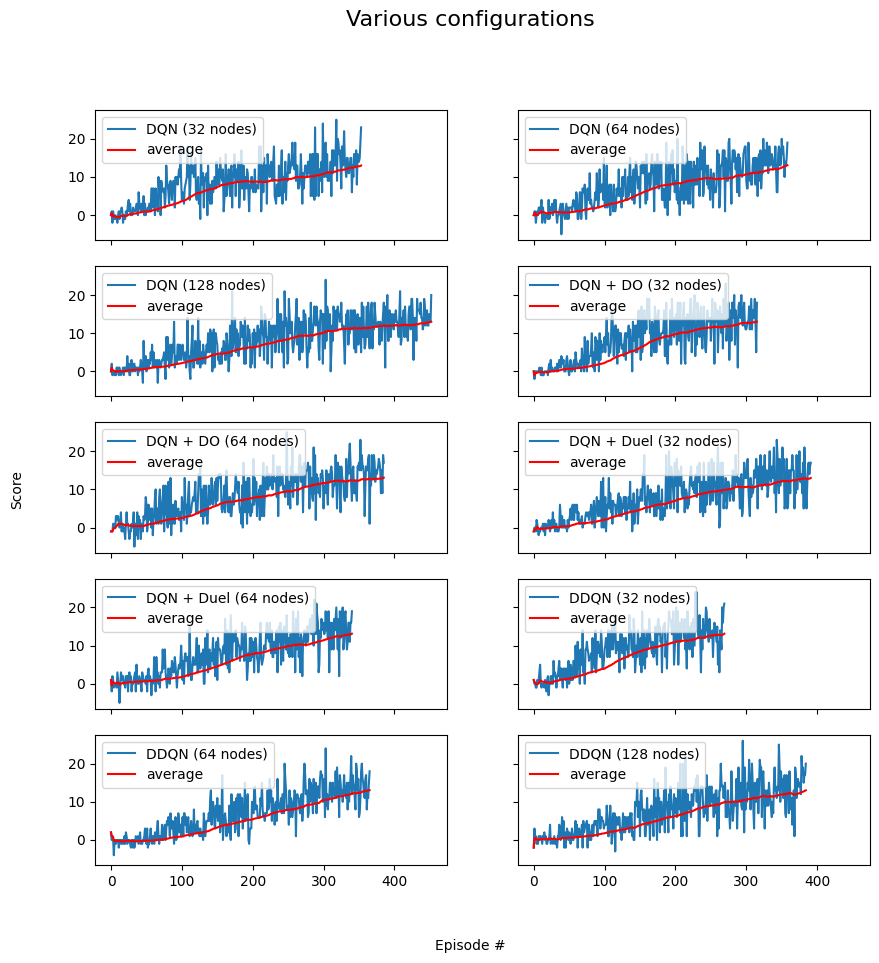

In [15]:
fig, axs = plt.subplots(5, 2, figsize=(10, 10), dpi=100, sharex=True, sharey=True)
fig.suptitle('Various configurations', fontsize=16)
fig.text(0.5, 0.04, 'Episode #', ha='center')
fig.text(0.04, 0.5, 'Score', va='center', rotation='vertical')

for ii in range(len(data)):
    row = math.floor(ii / 2)
    col = ii % 2

    axs[row, col].plot(np.arange(len(data[ii]['scores'])), data[ii]['scores'], label=data[ii]['title'])
    axs[row, col].plot(np.arange(len(data[ii]['avgs'])), data[ii]['avgs'], c='r', label='average')

    axs[row, col].legend(loc='upper left');

#### Run the best agent

Episode 1	Average Score: 0.00	Current Action: 2
Episode 2	Average Score: 1.00	Current Action: 3
Episode 3	Average Score: 7.330	Current Action: 0
Episode 4	Average Score: 5.75	Current Action: 3
Episode 5	Average Score: 6.40	Current Action: 2
Episode 6	Average Score: 7.170	Current Action: 2
Episode 7	Average Score: 8.140	Current Action: 3
Episode 8	Average Score: 7.50	Current Action: 3
Episode 9	Average Score: 6.78	Current Action: 2
Episode 10	Average Score: 6.50	Current Action: 2
Episode 11	Average Score: 6.820	Current Action: 3
Episode 12	Average Score: 6.33	Current Action: 2
Episode 13	Average Score: 6.08	Current Action: 3
Episode 14	Average Score: 6.14	Current Action: 3
Episode 15	Average Score: 5.73	Current Action: 3
Episode 16	Average Score: 5.44	Current Action: 2
Episode 17	Average Score: 5.29	Current Action: 20
Episode 18	Average Score: 5.830	Current Action: 3
Episode 19	Average Score: 5.74	Current Action: 2
Episode 20	Average Score: 5.60	Current Action: 2


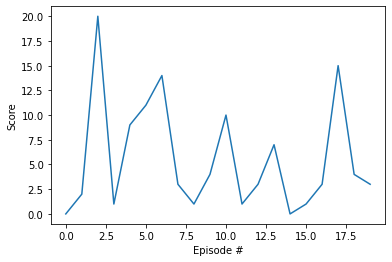

In [18]:
# Initialize the agent and load the weights from file
agent = Agent(state_size=state_size, action_size=action_size, seed=0, layer_1=32, layer_2=32, use_dropout=False, use_dueling=False, use_double=True)
checkpoint = './best_agent_ddqn_32_checkpoint.pth'
agent.qnetwork_local.load_state_dict(torch.load(checkpoint))

num_episodes = 20
scores = []
for i_episode in range(1,num_episodes + 1):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.act(state, eps=0)               # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished

        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        print('\rEpisode {}\tCurrent Score: {:.2f}\tCurrent Action: {}'.format(i_episode, score, action), end="")
        if done:                                       # exit loop if episode finished
            scores.append(score)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
            break

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [19]:
env.close()